<a href="https://colab.research.google.com/github/pjskek/Data-Analysis-with-Open-Source/blob/main/%EC%98%A4%ED%94%88%EC%86%8C%EC%8A%A4_%EB%8D%B0%EC%9D%B4%ED%84%B0_%EB%B6%84%EC%84%9D_14%EA%B0%95_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 14강 비정형 데이터 분석 : 패션 사진 데이터 활용

### 목표

- 비정형 데이터를 인공지능 모델로 분석하여 실무에서 활용 가능한 보고서 형태로 가공

- 패션 트렌드라는 구체적인 주제를 통해, 비정형 데이터 분석의 실질적인 활용 방안을 경험하고자 함


### 분석 프로세스 개요

1. 데이터 수집
  - requests를 이용한 RSS 데이터 수집
  - lxml을 이용한 XML 파싱
  - 이미지 데이터 추출
2. VLM을 이용한 이미지 분석
  - 프롬프트를 이용한 이미지 필터링
  - 프롬프트를 이용한 스타일 분석
3. LLM을 이용한 키워드 분석 및 보고서 작성
  - 텍스트 전처리
  - 색상 및 스타일 키워드 추출
  - 워드 클라우드 분석
  - 보고서 작성

# 주의 : 런타임 GPU 로 설정 필요

In [7]:
# 4bit VLM 처리를 위한 bitsandbytes 설치
# LLM 처리를 위한 VLLM 설치 (오래걸리는 작업(>5분)이므로 미리 실행!)
!pip install bitsandbytes==0.45.3 vllm==0.7.3 transformers==4.48.2
# 필요 시 세션 재시작

In [1]:
# 한글 처리를 위한 matplotlib 설정 (1)

!sudo apt-get install -y fonts-nanum
!sudo fc-cache –fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.


- 런타임 -> 세션 다시 시작

In [1]:
# 한글 처리를 위한 matplotlib 설정 (2)

import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')

# 1. 데이터 수집 및 전처리

## 14-1 RSS 피드에서 이미지 URL 추출

In [2]:
import requests
from lxml import etree
from lxml.html import fromstring
import pandas as pd

def extract_unique_images(rss_url):
    ## 주어진 RSS 피드 URL에서 고유한 이미지 URL들을 추출하는 함수 정의
    try:
        ## requests 라이브러리를 사용하여 RSS 피드 URL로부터 내용을 가져옴
        response = requests.get(rss_url)
        ## 가져온 XML 응답 내용을 lxml의 etree.fromstring으로 파싱하여 XML 트리 root를 생성
        root = etree. fromstring (response.content)
        image_urls = set()

        ## XML 트리에서 모든 'item' 태그를 XPath를 사용하여 순회
        for item in root.xpath('//item'):
            description = item.find('description')
            if description is not None and description.text:
                ## description의 텍스트 내용을 lxml.html.fromstring으로 파싱하여 HTML 트리를 생성
                html_tree = fromstring(description.text)
                ## HTML 트리에서 첫 번째 <img> 태그의 'src' 속성 값을 XPath를 사용하여 추출
                img_url = html_tree.xpath('string(//img/@src)')
                if img_url:
                    image_urls.add(img_url)

        return list(image_urls)

    except Exception as e:
        ## 오류 발생 시 오류 메시지를 출력하고 빈 리스트를 반환
        print(f"Error occurred: {e}")
        return []

rss_url = "https://glltn.com/feed/"
## extract_unique_images 함수를 호출하여 고유한 이미지 URL들을 추출
unique_images = extract_unique_images(rss_url)

## 추출된 이미지 URL 리스트를 사용하여 'image'라는 열을 가진 pandas DataFrame을 생성
df = pd.DataFrame(unique_images, columns=["image"])

In [3]:
df

,image
0,https://glltn.com/wp-content/blogs.dir/1/files...
1,https://glltn.com/wp-content/blogs.dir/1/files...
2,https://glltn.com/wp-content/blogs.dir/1/files...
3,https://glltn.com/wp-content/blogs.dir/1/files...
4,https://glltn.com/wp-content/blogs.dir/1/files...
5,https://glltn.com/wp-content/blogs.dir/1/files...
6,https://glltn.com/wp-content/blogs.dir/1/files...
7,https://glltn.com/wp-content/blogs.dir/1/files...
8,https://glltn.com/wp-content/blogs.dir/1/files...
9,https://glltn.com/wp-content/blogs.dir/1/files...


## 14-2 수집 데이터 확인

In [4]:
from IPython.display import display, HTML

def path_to_image_html(path):
    ## 이미지 경로를 HTML img 태그로 변환하는 함수
    return f'<img src="{path}" width="300" />'

## DataFrame의 스타일을 설정하여 이미지 너비를 300px로 지정
df.style.set_table_styles([{'selector': 'img', 'props': 'width: 300px;'}])

## DataFrame을 HTML로 변환하여 출력. 이미지 열은 path_to_image_html 함수로 포맷팅
display(HTML(df.to_html(escape=False, formatters=dict(**{'image': path_to_image_html}))))

,image
0,
1,
2,
3,
4,
5,
6,
7,
8,
9,


## 2. VLM을 이용한 이미지 분석

## 14-3 VLM 모델 로드

In [5]:
import torch
from PIL import Image
from transformers import AutoModel, AutoTokenizer

## 'openbmb/MiniCPM-V-2_6-int4' 모델을 사전 훈련된 가중치와 함께 로드
## trust_remote_code=True는 허브에서 사용자 정의 코드를 실행할 수 있도록 허용
model = AutoModel.from_pretrained('openbmb/MiniCPM-V-2_6-int4', trust_remote_code=True)
## 로드된 모델에 해당하는 토크나이저를 로드
tokenizer = AutoTokenizer.from_pretrained('openbmb/MiniCPM-V-2_6-int4', trust_remote_code=True)
## 모델을 평가 모드로 설정 (드롭아웃 등 훈련 시에만 필요한 기능 비활성화)
model.eval()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
`low_cpu_mem_usage` was None, now default to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

MiniCPMV(
  (llm): Qwen2ForCausalLM(
    (model): Qwen2Model(
      (embed_tokens): Embedding(151666, 3584)
      (layers): ModuleList(
        (0-27): 28 x Qwen2DecoderLayer(
          (self_attn): Qwen2Attention(
            (q_proj): Linear4bit(in_features=3584, out_features=3584, bias=True)
            (k_proj): Linear4bit(in_features=3584, out_features=512, bias=True)
            (v_proj): Linear4bit(in_features=3584, out_features=512, bias=True)
            (o_proj): Linear4bit(in_features=3584, out_features=3584, bias=False)
          )
          (mlp): Qwen2MLP(
            (gate_proj): Linear4bit(in_features=3584, out_features=18944, bias=False)
            (up_proj): Linear4bit(in_features=3584, out_features=18944, bias=False)
            (down_proj): Linear4bit(in_features=18944, out_features=3584, bias=False)
            (act_fn): SiLU()
          )
          (input_layernorm): Qwen2RMSNorm((3584,), eps=1e-06)
          (post_attention_layernorm): Qwen2RMSNorm((3584,), eps=

![](https://farm3.staticflickr.com/2677/4434956914_6e95a22940_z.jpg)

## 14-4 이미지 질문 응답 예시

In [6]:
from transformers import set_seed

## 재현성을 위해 시드(seed)를 42로 설정
set_seed(42)
## 예시 이미지 URL 정의
image_url = 'https://farm3.staticflickr.com/2677/4434956914_6e95a22940_z.jpg'
## requests로 이미지 다운로드 후 PIL Image 객체로 열고 RGB 형식으로 변환
image = Image.open(requests.get(image_url, stream=True).raw).convert('RGB')
## 이미지에 대한 질문 정의
question = 'how many cats in the photo?'
## 모델 입력 형식에 맞춰 메시지 구성 (이미지와 질문 포함)
msgs = [{'role': 'user', 'content': [image, question]}]
## 모델의 chat 함수를 호출하여 이미지와 질문에 대한 응답 생성
result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer)
## 모델의 응답 출력
print(result)

preprocessor_config.json:   0%|          | 0.00/714 [00:00<?, ?B/s]

processing_minicpmv.py: 0.00B [00:00, ?B/s]

image_processing_minicpmv.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6-int4:
- image_processing_minicpmv.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6-int4:
- processing_minicpmv.py
- image_processing_minicpmv.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
/usr/local/lib/python3.12/dist-packages/transformers/models/auto/image_processing_auto.py:590: FutureWarning: The image_processor_class argument is deprecated and will be removed in v4.42. Please use `slow_image_processor_class`, or `fast_image_processor_class` instead
  warnings.warn(
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=

1


In [7]:
set_seed(42)
## 이미지에 대한 질문을 업데이트. 책 표지의 고양이도 포함하도록 요청
question = 'how many cats in the photo? including the books cover.'
## 모델 입력 형식에 맞춰 메시지 구성 (이전에 로드된 이미지와 업데이트된 질문 포함)
msgs = [{'role': 'user', 'content': [image, question]}]
## 모델의 chat 함수를 호출하여 업데이트된 질문에 대한 응답 생성
result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer)
## 모델의 응답 출력
print(result)

1


In [8]:
set_seed(42)
## 이미지에 대한 질문을 'describe the photo'로 설정하여 이미지 내용을 설명하도록 요청
question = 'describe the photo'
## 모델 입력 형식에 맞춰 메시지 구성 (이전에 로드된 이미지와 설명 요청 질문 포함)
msgs = [{'role': 'user', 'content': [image, question]}]
## 모델의 chat 함수를 호출하여 이미지에 대한 설명을 생성
result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer)
## 모델의 응답 (이미지 설명) 출력
print(result)

The photo shows a book with the title "why dogs are better than cats" and an image of a cat sitting on top of a dog's head. The book is placed on a flat surface, and next to it stands a real cat that appears to be looking at the book cover with some curiosity or disapproval.


## 14-5 의류 이미지 여부 판단

In [9]:
def is_picture_of_clothing(image_url):
    ## 이미지 URL이 의류 사진인지 판단하는 함수
    # 의류가 포함된 사진인지 확인하는 질문 작성 (영어로)
    question = 'Is this a picture of clothing? MUST say yes or no. '
    image = Image.open(requests.get(image_url, stream=True).raw).convert('RGB')
    msgs = [{'role': 'user', 'content': [image, question]}]
    result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer, temperature=0.1)
    print(result)
    ## 응답에 'yes'가 포함되어 있는지 확인하여 True/False 반환
    return 'yes' in result.lower()

## DataFrame의 'image' 열에 함수를 적용하여 'is_clothing' 열에 결과 저장
df['is_clothing'] = df['image'].apply(is_picture_of_clothing)

No.
Yes.
Yes.
Yes.
Yes.
Yes.
Yes.
Yes.
Yes.
No.
Yes.
No.


## 14-6 의류 판단 결과 시각화

In [10]:
display(HTML(df.to_html(escape=False, formatters=dict(**{'image': path_to_image_html}))))

,image,is_clothing
0,,False
1,,True
2,,True
3,,True
4,,True
5,,True
6,,True
7,,True
8,,True
9,,False


## 14-7 의류 이미지 필터링

In [11]:
## 'is_clothing' 열의 값이 True인 행들만 필터링하여 DataFrame을 업데이트
df= df[df['is_clothing']]

In [12]:
display(HTML(df.to_html(escape=False, formatters=dict(**{'image': path_to_image_html}))))

,image,is_clothing
1,,True
2,,True
3,,True
4,,True
5,,True
6,,True
7,,True
8,,True
10,,True


## 14-8 의류 스타일 분석

In [13]:
def describe_style(image_url):
    ## 주어진 이미지 URL의 의류 스타일을 분석하는 함수
    question = 'Analyze the style of the clothes. Please let me explain the colors and trend changes'
    image = Image.open(requests.get(image_url, stream=True).raw).convert('RGB')
    msgs = [{'role': 'user', 'content': [image, question]}]
    ## 모델의 chat 함수를 호출하여 이미지에 대한 스타일 분석 응답 생성
    result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer)
    return result

## 필터링된 DataFrame의 'image' 열에 describe_style 함수를 적용
## 결과는 'style'이라는 새로운 열에 저장
df['style'] = df['image'].apply(describe_style)

/tmp/ipython-input-1482516394.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['style'] = df['image'].apply(describe_style)


In [14]:
display(HTML(df.to_html(escape=False, formatters=dict(**{'image': path_to_image_html}))))

,image,is_clothing,style
1,,True,"The style of the shoes in the image leans towards a utilitarian and outdoor-inspired aesthetic. The choice of materials, such as suede or nubuck leather, along with the robust construction, suggests these are designed for durability and comfort during activities like hiking or casual urban exploration.\n\nIn terms of color, the earthy tones of brown and tan are versatile and timeless, often associated with natural elements and outdoor gear. These colors have been popular in various fashion trends over the years, particularly in outdoor and adventure-related apparel, where they offer practical benefits by blending with natural environments.\n\nRegarding trend changes, there has been a noticeable shift in recent years toward more sustainable and eco-friendly practices in the fashion industry. This includes the use of recycled materials and an emphasis on longevity rather than fast fashion. While the specific materials used here cannot be determined without further information, the overall design does not immediately suggest cutting-edge sustainability features but rather classic craftsmanship that could appeal to consumers looking for quality over quick fashion cycles.\n\nIn summary, the shoes reflect a traditional outdoor style that remains relevant due to its practicality and versatility. If the materials are indeed environmentally conscious, this would align with current trends favoring sustainable fashion choices."
2,,True,"The style of the clothes in the image suggests a casual and possibly Scandinavian influence, characterized by the use of natural colors and traditional patterns. The sweater features a muted color palette with shades of green, brown, and beige, which are often associated with autumnal tones and earthy hues. These colors can evoke a sense of warmth and comfort, making them popular choices for fall and winter clothing.\n\nThe pattern on the sweater is reminiscent of traditional Nordic or Icelandic designs, known as ""landspatter"" or ""nordic knit,"" which typically include geometric shapes and motifs that reflect the environment and culture of these regions. This type of design has seen a resurgence in popularity due to its timeless appeal and cultural significance.\n\nIn terms of trend changes, such styles have experienced periods of prominence and decline, but they tend to resurface periodically, especially when there's a shift towards more sustainable and regionally inspired fashion. The return of these patterns could indicate a broader movement towards embracing heritage and traditional craftsmanship in contemporary fashion trends."
3,,True,"The style of the clothes in the image leans towards a casual, possibly vintage-inspired look. The olive green jacket has a practical and rugged appearance, which is often associated with military or outdoor attire. This color choice is versatile and can be seen as a timeless fashion statement that doesn't follow seasonal trends but rather offers a classic appeal.\n\nUnderneath the jacket, there's a layered ensemble consisting of a blue shirt and a brown vest. The layering suggests an approach to dressing for comfort and adaptability to changing temperatures, a trend that has been popular in various forms over the years. The blue shirt adds a subtle contrast to the earthy tones of the outerwear, while the brown vest introduces texture and depth to the outfit.\n\nOverall, the clothing items seem to prioritize functionality and comfort over the latest fashion trends, indicating a preference for enduring styles over fleeting fads. Such a wardrobe could be indicative of someone who values simplicity, practicality, and perhaps a nod to past fashion eras."
4,,True,"The style of the clothes in the image leans towards a minimalist and functional design, which is often associated with contemporary streetwear or urban casual fashion. The olive green color of both coats suggests a preference for earthy tones that are versatile and can be easil

# 3. LLM을 이용한 키워드 분석 및 보고서 작성

## 14-9 언어 모델(LLM) 로드

In [15]:
from vllm import LLM, SamplingParams

## vLLM 라이브러리를 사용하여 'LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct' 모델을 로드
## gpu_memory_utilization은 GPU 메모리 사용 비율을 0.5로 설정
## max_model_len은 모델이 처리할 수 있는 최대 토큰 길이를 10000으로 설정
llm= LLM(model='LGAI-EXAONE/EXAONE-3.5-2.4B-instruct',gpu_memory_utilization= 0.5,max_model_len=10000)

INFO 10-14 04:13:29 __init__.py:207] Automatically detected platform cuda.


config.json: 0.00B [00:00, ?B/s]

INFO 10-14 04:13:30 config.py:2444] Downcasting torch.float32 to torch.float16.
INFO 10-14 04:13:49 config.py:549] This model supports multiple tasks: {'reward', 'generate', 'classify', 'score', 'embed'}. Defaulting to 'generate'.
INFO 10-14 04:13:49 llm_engine.py:234] Initializing a V0 LLM engine (v0.7.3) with config: model='LGAI-EXAONE/EXAONE-3.5-2.4B-instruct', speculative_config=None, tokenizer='LGAI-EXAONE/EXAONE-3.5-2.4B-instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=10000, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='xgrammar'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_time=

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/563 [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

INFO 10-14 04:13:51 cuda.py:178] Cannot use FlashAttention-2 backend for Volta and Turing GPUs.
INFO 10-14 04:13:51 cuda.py:226] Using XFormers backend.
INFO 10-14 04:13:53 model_runner.py:1110] Starting to load model LGAI-EXAONE/EXAONE-3.5-2.4B-instruct...
INFO 10-14 04:13:53 weight_utils.py:254] Using model weights format ['*.safetensors']


model-00001-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.65G [00:00<?, ?B/s]

INFO 10-14 04:19:59 weight_utils.py:270] Time spent downloading weights for LGAI-EXAONE/EXAONE-3.5-2.4B-instruct: 366.429178 seconds


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Loading safetensors checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]


INFO 10-14 04:20:41 model_runner.py:1115] Loading model weights took 4.5146 GB
INFO 10-14 04:20:44 worker.py:267] Memory profiling takes 2.41 seconds
INFO 10-14 04:20:44 worker.py:267] the current vLLM instance can use total_gpu_memory (14.74GiB) x gpu_memory_utilization (0.50) = 7.37GiB
INFO 10-14 04:20:44 worker.py:267] model weights take 4.51GiB; non_torch_memory takes 0.02GiB; PyTorch activation peak memory takes 0.98GiB; the rest of the memory reserved for KV Cache is 1.86GiB.
INFO 10-14 04:20:45 executor_base.py:111] # cuda blocks: 1625, # CPU blocks: 3495
INFO 10-14 04:20:45 executor_base.py:116] Maximum concurrency for 10000 tokens per request: 2.60x
INFO 10-14 04:20:49 model_runner.py:1434] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-of-memory error occurs during cudagraph capture, consider decreasing `gpu_memory_utili

Capturing CUDA graph shapes: 100%|██████████| 35/35 [00:39<00:00,  1.12s/it]

INFO 10-14 04:21:29 model_runner.py:1562] Graph capturing finished in 39 secs, took 0.21 GiB
INFO 10-14 04:21:29 llm_engine.py:436] init engine (profile, create kv cache, warmup model) took 47.56 seconds


## 14-10 색상 정보 추출

In [16]:
from vllm import SamplingParams ## SamplingParams 임포트가 필요

def extract_color(style):
  ## 주어진 스타일 설명 텍스트에서 색상을 한글로 추출하는 함수
  prompt = [
      {
          "role": "system",
          "content": "You are EXAONE model from LG AI Research, a helpful assistant."
      },
      {
          "role": "user",
          "content": f"다음의 글에서 색상을 한글로 추출해주세요. 생삭 외에 다른 정보는 적지 말아주세요.\n{style}" # vlm이 작성한 글에서 색상 정보 추출, 한글로 번역하면서
      }
  ]
  ## 샘플링 파라미터 설정 (온도, top_p, 최대 토큰 수)
  sampling_params = SamplingParams(temperature=0.2, top_p=0.95, max_tokens=1024)
  ## LLM 모델을 사용하여 프롬프트에 대한 응답 생성
  result = llm.chat(prompt, sampling_params)[0].outputs[0].text
  print(result)
  return result

## DataFrame의 'style' 열에 extract_color 함수를 적용
## 결과는 'color'라는 새로운 열에 저장
df['color'] = df['style'].apply(extract_color)

INFO 10-14 04:24:02 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  2.34it/s, est. speed input: 726.39 toks/s, output: 28.12 toks/s]


**색상:**
- 갈색
- 탄색


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  2.48it/s, est. speed input: 670.08 toks/s, output: 34.87 toks/s]


**색상:**
- 녹색
- 갈색
- 베이지


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  2.98it/s, est. speed input: 789.91 toks/s, output: 32.91 toks/s]


- **올리브 그린** (Olive Green)


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  2.90it/s, est. speed input: 908.93 toks/s, output: 31.94 toks/s]


- **올리브 그린** (Olive Green)


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  2.61it/s, est. speed input: 641.54 toks/s, output: 36.66 toks/s]


**색상:**
- **검정색** (Black)


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s, est. speed input: 578.39 toks/s, output: 35.90 toks/s]


- **어두운 초록색** (Dark Green)
- **빨간색** (Red)


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s, est. speed input: 538.46 toks/s, output: 35.90 toks/s]


**색상:**
- **흰색/크림색**
- **파란색**


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  3.41it/s, est. speed input: 1013.37 toks/s, output: 30.81 toks/s]


**색상:**
- 검정색


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  3.90it/s, est. speed input: 1088.54 toks/s, output: 27.41 toks/s]

**색상:** 검정색



/tmp/ipython-input-2362428255.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['color'] = df['style'].apply(extract_color)


## 14-11 스타일 키워드 추출

In [18]:
from vllm import SamplingParams ## SamplingParams 임포트가 필요

def extract_style(style):
  ## 주어진 스타일 설명 텍스트에서 스타일 키워드를 한글로 추출하는 함수
  prompt = [
      {
          "role": "system",
          "content": "You are EXAONE model from LG AI Research, a helpful assistant."
      },
      {
          "role": "user",
          "content": f"다음의 글에서 스타일을 한글로 추출해주세요. 색상 외에 다른 정보는 적지 말아주세요.\n{style}" # vlm이 작성한 글에서 스타일 키워드 추출, 한글로 번역하면서
      }
  ]
  ## 샘플링 파라미터 설정 (온도, top_p, 최대 토큰 수)
  sampling_params = SamplingParams(temperature=0.2, top_p=0.95, max_tokens=1024)
  ## LLM 모델을 사용하여 프롬프트에 대한 응답 생성
  result = llm.chat(prompt, sampling_params)[0].outputs[0].text
  print(result)
  return result

## DataFrame의 'style' 열에 extract_color 함수를 적용 (함수 이름은 이전과 동일하지만 기능 변경)
## 결과는 'keyword'라는 새로운 열에 저장
df['keyword'] = df['style'].apply(extract_style)


Processed prompts: 100%|██████████| 2/2 [00:01<00:00,  1.62it/s, est. speed input: 472.03 toks/s, output: 107.61 toks/s]


스타일: 캐주얼하면서도 세련된 감각

특징:
- 클래식한 오프화이트 또는 크림색 버튼업 셔츠로 편안함과 세련됨을 동시에 추구
- 가벼운 블루 데님 팬츠로 여름 분위기 연출, 다양한 계절에 활용 가능
- 부드러운 색상 조합으로 시각적 조화와 실용성 겸비
- 현대적인 캐주얼 트렌드를 반영하며 편안함과 세련됨을 동시에 추구



Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.06s/it, est. speed input: 253.17 toks/s, output: 38.73 toks/s]


스타일: 캐주얼하고 스칸디나비아 영향을 받음  
색상: 자연스러운 녹색, 갈색, 베이지색  
패턴: 전통적인 북유럽 또는 아이슬란드 디자인의 기하학적 무늬



Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.18s/it, est. speed input: 121.09 toks/s, output: 38.67 toks/s]


스타일: 캐주얼하고 빈티지한 느낌의 옷차림
- 실용적이고 거친 외관의 올리브 그린 재킷
- 계절을 초월한 클래식한 패션 스타일
- 편안함과 온도 변화에 따른 적응성을 중시하는 레이어드 룩
- 블루 셔츠와 브라운 조끼의 조화로운 조합
- 최신 트렌드보다 기능성과 편안함을 우선시
- 단순함과 실용성을 중시하는 경향



Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.31s/it, est. speed input: 239.02 toks/s, output: 39.84 toks/s]


미니멀리즘과 실용성을 중시하는 디자인

오레곤 그린 색상의 코트와 패딩 재킷

대용량 사이즈와 루즈 핏의 패딩 재킷

hooded 디자인으로 실용성 강조

회색 하의로 균형 잡힌 스타일



Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.56s/it, est. speed input: 95.52 toks/s, output: 41.11 toks/s]


**스타일 요약:**

- **클래식과 현대의 융합**: 고급스러운 검정 블레이저와 현대적인 타이다이 패턴의 바지가 조화롭게 어우러짐.
- **클래식 요소**: 높은 칼라와 큰 버튼의 블레이저는 전통적인 정장 스타일을 반영.
- **현대적 요소**: 타이다이 바지는 강렬한 색상과 패턴으로 개성 표현을 강조.
- **균형**: 정제된 이미지 유지와 독특한 스타일 표현의 조화.



Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.96s/it, est. speed input: 147.87 toks/s, output: 40.93 toks/s]


스타일: 미니멀리즘과 현대적인 감각을 추구하는 스타일

주요 특징:
- 어두운 녹색 셔츠: 클래식한 버튼업 디자인, 높은 칼라와 긴 소매로 따뜻함과 세련됨을 더함
- 버건디 터틀넥: 고급스러움과 색상 대비 제공
- 패턴: 폴카닷 shorts로 재미와 현대적 감각 더함



Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it, est. speed input: 151.91 toks/s, output: 40.66 toks/s]


스타일: 캐주얼하면서도 스타일리시한

특징:
- 오프화이트 또는 크림색 버튼업 셔츠 (클래식, 다양성과 영원한 매력)
- 가벼운 블루 데님 팬츠 (여름 분위기, 편안함)
- 부드러운 색상 조화 (오프화이트 셔츠와 블루 팬츠)
- 실용적이고 계절 변화에 따른 레이어드 가능성



Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.68s/it, est. speed input: 80.26 toks/s, output: 41.63 toks/s]


스타일: 현대적이고 간결한 패션 트렌드를 반영하며, 편안함과 친환경적인 요소를 중시합니다. 어두운 색상은 세련되고 고전적인 느낌을 주며, 유연한 소매는 공식적인 요소와 캐주얼함을 결합합니다.

조켓트: 느슨한 핏과 허리띠 사용으로 현대적인 테일러링을 보여주며, 최근 인기 있는 스타일로 실용성과 세련됨을 동시에 추구합니다. 미니멀리즘 디자인에 부합하며 장식보다는 깔끔한 라인과 기능성에 초점을 맞춥니다.

주요 색상: 검정색은 클래식하고 유행을 타지 않는 색상으로, 다양한 피부톤과 잘 어울리며 다른 색상과도 잘 어울립니다.



Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.91s/it, est. speed input: 145.02 toks/s, output: 40.84 toks/s]

스타일: 미니멀리즘과 현대적인 캐주얼 패션, 스트리트웨어 스타일

특징:
- 검정 셔츠: 세련되고 간결한 이미지 전달
- 긴 소매와 Henley 스타일 목선: 편안함과 움직임의 자유 강조
- 루즈핏: 편안함과 실용성 중시
- 간결한 디자인: 로고나 패턴 없음, 클래식하고 세련된 스타일 선호



/tmp/ipython-input-1464349835.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['keyword'] = df['style'].apply(extract_style)


In [19]:
display(HTML(df.to_html(escape=False, formatters=dict(**{'image': path_to_image_html}))))

,image,is_clothing,style,color,keyword
1,,True,"The style of the shoes in the image leans towards a utilitarian and outdoor-inspired aesthetic. The choice of materials, such as suede or nubuck leather, along with the robust construction, suggests these are designed for durability and comfort during activities like hiking or casual urban exploration.\n\nIn terms of color, the earthy tones of brown and tan are versatile and timeless, often associated with natural elements and outdoor gear. These colors have been popular in various fashion trends over the years, particularly in outdoor and adventure-related apparel, where they offer practical benefits by blending with natural environments.\n\nRegarding trend changes, there has been a noticeable shift in recent years toward more sustainable and eco-friendly practices in the fashion industry. This includes the use of recycled materials and an emphasis on longevity rather than fast fashion. While the specific materials used here cannot be determined without further information, the overall design does not immediately suggest cutting-edge sustainability features but rather classic craftsmanship that could appeal to consumers looking for quality over quick fashion cycles.\n\nIn summary, the shoes reflect a traditional outdoor style that remains relevant due to its practicality and versatility. If the materials are indeed environmentally conscious, this would align with current trends favoring sustainable fashion choices.",**색상:**\n- 갈색\n- 탄색,"스타일: 캐주얼하면서도 세련된 감각\n\n특징:\n- 클래식한 오프화이트 또는 크림색 버튼업 셔츠로 편안함과 세련됨을 동시에 추구\n- 가벼운 블루 데님 팬츠로 여름 분위기 연출, 다양한 계절에 활용 가능\n- 부드러운 색상 조합으로 시각적 조화와 실용성 겸비\n- 현대적인 캐주얼 트렌드를 반영하며 편안함과 세련됨을 동시에 추구"
2,,True,"The style of the clothes in the image suggests a casual and possibly Scandinavian influence, characterized by the use of natural colors and traditional patterns. The sweater features a muted color palette with shades of green, brown, and beige, which are often associated with autumnal tones and earthy hues. These colors can evoke a sense of warmth and comfort, making them popular choices for fall and winter clothing.\n\nThe pattern on the sweater is reminiscent of traditional Nordic or Icelandic designs, known as ""landspatter"" or ""nordic knit,"" which typically include geometric shapes and motifs that reflect the environment and culture of these regions. This type of design has seen a resurgence in popularity due to its timeless appeal and cultural significance.\n\nIn terms of trend changes, such styles have experienced periods of prominence and decline, but they tend to resurface periodically, especially when there's a shift towards more sustainable and regionally inspired fashion. The return of these patterns could indicate a broader movement towards embracing heritage and traditional craftsmanship in contemporary fashion trends.",**색상:**\n- 녹색\n- 갈색\n- 베이지,"스타일: 캐주얼하고 스칸디나비아 영향을 받음 \n색상: 자연스러운 녹색, 갈색, 베이지색 \n패턴: 전통적인 북유럽 또는 아이슬란드 디자인의 기하학적 무늬"
3,,True,"The style of the clothes in the image leans towards a casual, possibly vintage-inspired look. The olive green jacket has a practical and rugged appearance, which is often associated with military or outdoor attire. This color choice is versatile and can be seen as a timeless fashion statement that doesn't follow seasonal trends but rather offers a classic appeal.\n\nUnderneath the jacket, there's a layered ensemble consisting of a blue shirt and a brown vest. The layering suggests an approach to dressing for comfort and adaptability to changing temperatures, a trend that has been popular in various forms over the years. The blue shirt adds a subtle contrast to the earthy tones of the outerwear, while the brown vest introduces texture and depth to the outfit.\n\nOverall, the clothing items seem to prioritize functionality and comfort over the latest fashion trends, indicating a preference for enduring styles over fleeting fads. Such a wardrobe could be indicative of someone who values simplicity, pract

## 14-12 텍스트 데이터 정제

In [20]:
import re

def clean_text(text):
    ## 텍스트에서 특수 문자 및 HTML 태그를 제거하고 소문자로 변환하는 함수
    if isinstance(text, str):
       ## 영문, 숫자, 한글, 공백을 제외한 모든 문자 제거
       text = re.sub(r'[^a-zA-Z0-9가-힣\s]', '', text)
       ## HTML 태그 제거
       text = re.sub(r'<[^>]*>', '', text)
       ## 텍스트를 소문자로 변환
       text = text.lower()
       return text
    else:
        return ""

## 'color' 열의 텍스트 데이터 정제
df['color'] = df['color'].apply(clean_text)
## 'keyword' 열의 텍스트 데이터 정제
df['keyword'] = df['keyword'].apply(clean_text)

/tmp/ipython-input-2796376683.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['color'] = df['color'].apply(clean_text)
/tmp/ipython-input-2796376683.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['keyword'] = df['keyword'].apply(clean_text)


## 14-13 워드 클라우드 생성 및 시각화

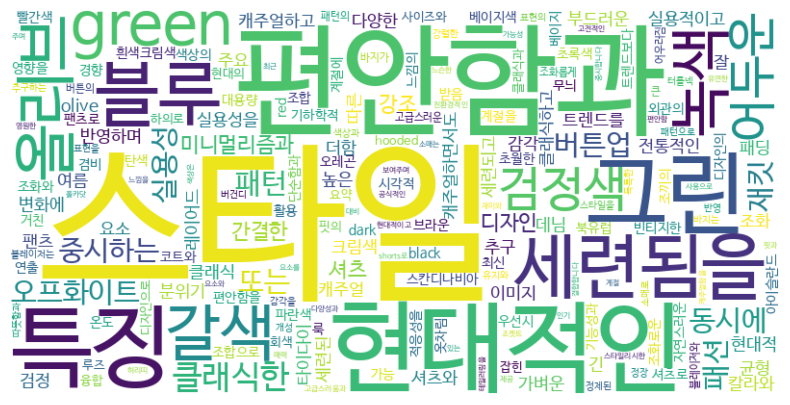

In [21]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def get_word_count(df):
    ## DataFrame의 'color'와 'keyword' 열에서 단어 빈도를 계산하는 함수
    if not df.empty:
        ## 'color' 열의 모든 단어를 리스트로 합침
        all_nouns = df['color'].apply(str.split).sum()
        ## 'keyword' 열의 모든 단어를 추가
        all_nouns += df['keyword'].apply(str.split).sum()
        ## '색상' 단어를 제외한 모든 단어를 필터링
        all_nouns = [word for word in all_nouns if word not in ['색상']]
        ## 단어 빈도를 Counter 객체로 반환
        return Counter(all_nouns)
    return Counter() ## DataFrame이 비어있으면 빈 Counter 반환

def create_wordcloud(word_count):
    ## 단어 빈도수를 기반으로 워드 클라우드를 생성하고 시각화하는 함수
    if not word_count: ## 단어 빈도가 없으면 워드클라우드 생성하지 않음
        print("No words to generate word cloud.")
        return

    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='viridis',
        font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf' ## 한글 폰트 경로 지정
        ).generate_from_frequencies(word_count)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off") ## 축 표시 제거
    plt.show() ## 워드 클라우드 출력

## DataFrame에서 단어 빈도 계산
word_count = get_word_count(df)
## 계산된 단어 빈도로 워드 클라우드 생성 및 시각화
create_wordcloud(word_count)

## 14-14 트렌드 분석 보고서 생성 프롬프트 구성 및 실행

## 14-15 분석 보고서 시각화

In [22]:
from vllm import SamplingParams ## SamplingParams 임포트가 필요

## 시스템 메시지로 시작하는 프롬프트 리스트 초기화
prompt = [
    {
        "role": "system",
        "content": "You are EXAONE model from LG AI Research, a helpful assistant."
    }
]
## DataFrame의 각 행을 순회하며 '스타일 노트'와 '이미지 URL'을 사용자 메시지로 추가
for row in df.itertuples():
  prompt.append({"role": "user", "content": f"스타일 노트: {row.style}\n 이미지 url:{row.image}"})
## 마지막으로, 종합적인 트렌드 분석 보고서 작성을 요청하는 사용자 메시지 추가
## 보고서 제목, 내용의 전문성, 마크다운 형식, 예시 이미지 포함을 지시
prompt.append({"role": "user", "content": "주어진 스타일 노트를 토대로 종합적인 트랜드 방향의 분석 보고서를 작성해주세요.보고서의 제목은 해외 룩북 스타일 분석입니다. 내용은 전문적이면서 명확하게 작성해주세요. 문서 형식은 markdown으로 만들어주세요"})

## 샘플링 파라미터 설정 (온도, top_p, 최대 토큰 수)
sampling_params = SamplingParams(temperature=0.2, top_p=0.95, max_tokens=4096)
## LLM 모델을 사용하여 구성된 프롬프트에 대한 응답 생성
result = llm.chat(prompt, sampling_params)[0].outputs[0].text


Processed prompts: 100%|██████████| 1/1 [00:20<00:00, 20.06s/it, est. speed input: 137.66 toks/s, output: 39.49 toks/s]


In [23]:
from IPython.display import display, Markdown

## LLM으로부터 생성된 결과(Markdown 형식의 보고서)를 Jupyter 환경에 표시
display(Markdown(result))

# 해외 룩북 스타일 분석 보고서

## 개요
본 보고서는 최근 여러 해외 패션 룩북에서 관찰되는 주요 스타일 트렌드를 종합적으로 분석하고, 그 특징과 미래 전망을 제시합니다. 다양한 컬렉션에서 추출된 데이터를 바탕으로 현재 패션 산업의 주요 동향을 파악하고자 합니다.

## 트렌드 분석

### 1. **실용성과 기능성의 강조**
- **스타일 예시**: 
  - **아웃도어 및 유틸리티 스타일**: 
    - **신발**: utilitarian 디자인과 robust construction을 갖춘 신발들 (예: suede 또는 nubuck leather 소재의 갈색 및 베이지색 색상의 부츠).
    - **옷**: 기능성과 내구성을 중시하는 디자인의 코트와 레이어링 아이템 (예: puffer jackets, hoodies).
  - **캐주얼 및 빈티지 스타일**:
    - **셔츠**: 클래식 버튼업 셔츠와 레이어링을 통한 편안함 제공 (예: olive green jacket과 blue shirt).
    - **바지**: 편안함과 실용성을 겸비한 데님 shorts와 polka dot 패턴의 셔츠.
  - **미니멀리즘과 현대적 접근**:
    - **셔츠**: 단순하면서도 세련된 디자인의 셔츠 (예: cream-colored button-up shirt, off-white shirt).
    - **아우터**: 기능적이고 간결한 디자인의 재킷 (예: black blazer with tie-dye pants).

### 2. **지속 가능성과 친환경 소재**
- **특징**: 최근 패션 트렌드는 환경 친화적인 소재와 생산 방식에 대한 관심이 증가하고 있습니다.
- **예시**:
  - **재활용 소재 사용**: 일부 컬렉션에서는 재활용 소재를 활용한 제품들이 주목받고 있습니다.
  - **장기적인 패션 사이클**: 품질과 내구성을 중시하는 디자인이 빠르게 변화하는 트렌드에 대응하는 방식으로 부상하고 있습니다.

### 3. **문화적 영감과 지역성**
- **스타일 예시**:
  - **전통적 패턴과 현대적 해석**: Nordic knit 패턴이나 vintage 요소를 현대적으로 재해석한 디자인 (예: tie-dye pants, polka dots).
  - **지역적 색채**: 자연스러운 색상 팔레트 (갈색, 베이지색, 녹색 등)를 활용한 클래식한 스타일 (예: olive green jacket).

### 4. **기능성과 편안함의 융합**
- **특징**: 현대 패션은 기능성과 편안함을 동시에 추구하며, 다양한 활동에 적합한 의류를 선호합니다.
- **예시**:
  - **활동성**: hiking boots와 puffer jackets의 조합.
  - **시즌 유연성**: 레이어링을 통한 계절 변화에 대한 적응력 (예: hoodies, turtlenecks).

## 결론
현재 패션 산업은 실용성과 기능성을 중심으로 한 디자인에서부터 지속 가능한 소재 사용과 문화적 영감을 반영한 창의적인 해석까지 다양한 트렌드를 경험하고 있습니다. 이러한 트렌드는 소비자들이 일상 생활에서의 편안함과 동시에 개인의 스타일 표현을 중시하는 경향을 반영하고 있습니다. 미래에는 이러한 경향이 더욱 강화되며, 친환경적 접근과 기술적 혁신이 결합된 새로운 디자인이 주목받을 것으로 예상됩니다.

---

이 보고서는 패션 트렌드의 현재 상태와 미래 전망을 종합적으로 분석하여 제공하였습니다. 각 트렌드 요소는 실제 패션 산업의 다양한 측면을 포괄하며, 이를 통해 소비자와 디자이너 모두에게 유용한 통찰을 제공합니다.